In [4]:
# %pip install pennylane pennylane-qiskit
# %pip install scikit-learn

Import Required Libraries: Import the necessary libraries for creating the variational classifier.

In [23]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Prepare the Dataset: For simplicity, we'll use the `make_moons` dataset from scikit-learn.

In [25]:
# Generate a toy dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
y = y * 2 - 1  # Convert labels to -1 and 1

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Define the Quantum Circuit: Create a quantum circuit that will be used as the variational classifier.

In [26]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation='X')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

Initialize the Weights: Initialize the weights for the variational circuit.

In [27]:
np.random.seed(42)
num_layers = 3
weights = np.random.randn(num_layers, n_qubits, 3)

Define the Cost Function: Define the cost function for training the variational classifier.

In [30]:
def cost(weights, X, y):
    predictions = np.array([circuit(weights, x) for x in X])
    return np.mean((predictions - y) ** 2)

Train the Classifier: Use an optimizer to train the variational classifier.

In [31]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
batch_size = 5

for i in range(steps):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    weights = opt.step(lambda w: cost(w, X_batch, y_batch), weights)

    # Compute the cost for the entire training set
    train_cost = cost(weights, X_train, y_train)
    print(f"Step {i+1}, Cost: {train_cost}")

Step 1, Cost: 1.1464841708484754
Step 2, Cost: 1.0110377010402356
Step 3, Cost: 0.9050757271732778
Step 4, Cost: 0.846861236752391
Step 5, Cost: 0.7770334797794304
Step 6, Cost: 0.6945043337901103
Step 7, Cost: 0.659506887875843
Step 8, Cost: 0.6186281095120569
Step 9, Cost: 0.6069973969365006
Step 10, Cost: 0.5891179614728241
Step 11, Cost: 0.5854416121448928
Step 12, Cost: 0.5916655193216819
Step 13, Cost: 0.575643881214918
Step 14, Cost: 0.5652143716530214
Step 15, Cost: 0.5489961731149975
Step 16, Cost: 0.5431601426503772
Step 17, Cost: 0.5367479938586925
Step 18, Cost: 0.5334951022087278
Step 19, Cost: 0.5308137550761958
Step 20, Cost: 0.5233805540433247
Step 21, Cost: 0.5308789675817043
Step 22, Cost: 0.5390190629103487
Step 23, Cost: 0.5420151780636062
Step 24, Cost: 0.5378271013943449
Step 25, Cost: 0.5323981436954142
Step 26, Cost: 0.5308376158109273
Step 27, Cost: 0.5304533644250531
Step 28, Cost: 0.525403657081914
Step 29, Cost: 0.5196295900909151
Step 30, Cost: 0.5148064516

Evaluate the Classifier: Evaluate the performance of the trained classifier on the test set.

In [32]:
predictions = [np.sign(circuit(weights, x)) for x in X_test]
accuracy = np.mean(predictions == y_test)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.9


Plot the Decision Boundary: Plot the decision boundary along with the training and test data points.

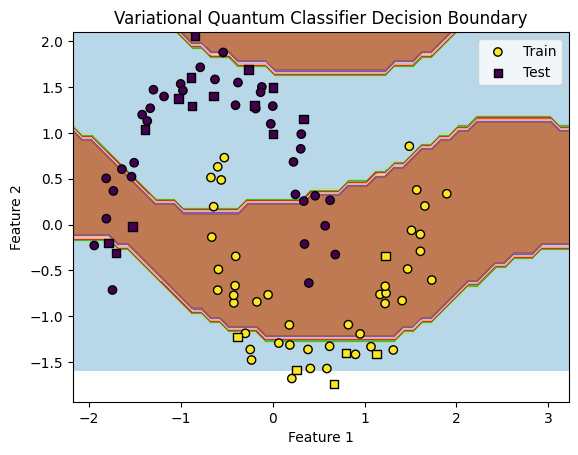

In [33]:
# Create a mesh grid for plotting the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points = scaler.transform(grid_points)

# Predict the class for each point in the grid
Z = np.array([np.sign(circuit(weights, point)) for point in grid_points])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', edgecolor='k', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', edgecolor='k', label='Test')
plt.legend()
plt.title("Variational Quantum Classifier Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()